In [23]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import GraphHelpers as GH
import matplotlib.dates as mdates

In [24]:
#Read in data
RawData=pd.read_csv('I:/Science Projects/I211007-02/Exception Files/04 Research/LoggedData/RainShelterBeta_Energy.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

## Check index for duplicates

In [25]:
seen = {}
dupes = []

for x in RawData.index:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
dupes

[]

## No duplicated data = good

In [26]:
#Bring in index data
DataIndex=pd.read_excel('.\IndexFiles\RadiationAndTempIndex.xlsx', 
                        sheet_name='Sensor positions',
                        usecols = range(9))
DataIndex.loc[:,'Irrigation'] = pd.Categorical(DataIndex.loc[:,'Irrigation'],['Expt','2D','7D','14D','21D','MD','LD'])
DataIndex.set_index('ColumnHeader',inplace=True)
DataIndex.dropna(inplace=True)
# #Apply indexes to data
DataTransposed = RawData.transpose() 
DataIndexed = pd.concat([DataIndex,DataTransposed], axis=1,sort=False)
DataIndexed.index.name='ColumnHeader'
DataIndexed.set_index(['Measurement','Irrigation','Species','Treatment','Units','Summary','Plot','Block'], 
                         append=False, inplace=True)
Data=DataIndexed.transpose()
Data.index = pd.to_datetime(Data.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back
Data = Data.drop(columns='Time',level=0) ## Drop blank time column
Data.sort_index(inplace=True)
Data.sort_index(axis=1,inplace=True)

## Set up Graphics Patterns

In [27]:
GPs = GH.SetGraphicsPatterns(Data.IR_SurfaceTemp.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = Data.index.min()
End = Data.index.max()

Irrigation
['2D', '7D', '14D', '21D', 'MD', 'LD']
Species
['Peas']
Treatments
MultiIndex([( '2D', 'Peas'),
            ( '7D', 'Peas'),
            ('14D', 'Peas'),
            ('21D', 'Peas'),
            ( 'MD', 'Peas'),
            ( 'LD', 'Peas')],
           )
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
         Lin     Col   Alp Mar     MFC
2D  Peas   -  orange  0.15   o  orange
7D  Peas   -   green  0.15   o   white
14D Peas   -  purple  0.15   o   white
21D Peas  --  orange  0.45   ^   white
MD  Peas  --   green  0.45   ^   white
LD  Peas  --  purple  0.45   ^   white


### Work out how long our date series in in weeks

In [28]:
from datetime import timedelta #Import function needed for doing date deltas 
FirstMeasurement  = Data.index.min(axis=0)
LastMeasurement = Data.index.max(axis=0)
Duration = (LastMeasurement - FirstMeasurement)/timedelta(weeks=1)
ExptDuration = np.round(Duration,decimals=0) #weeks
ExptDuration

9.0

### Graph data in two weekly blocks to see how it looks

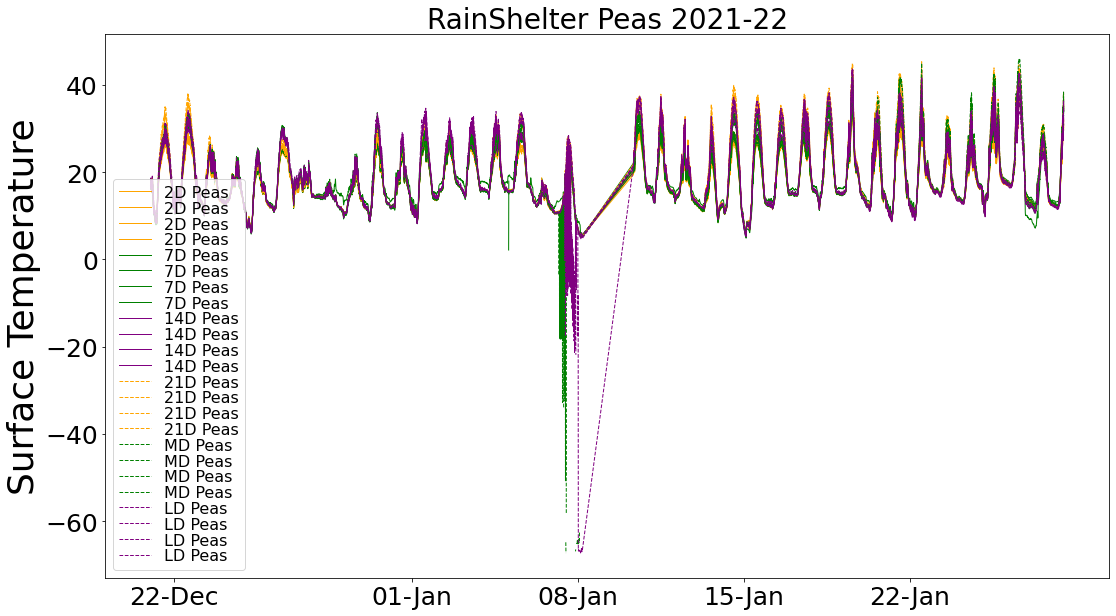

In [29]:
Fig = plt.figure(figsize=(18, 10))
ax = Fig.add_subplot(1,1,1)
GH.AddIndexedPlot(Data.IR_SurfaceTemp.loc['2021-12-21 0:00':,:],ax,GPs,1)
plt.ylabel('Surface Temperature', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Peas 2021-22', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05,)
ledg.get_title().set_fontsize(20)

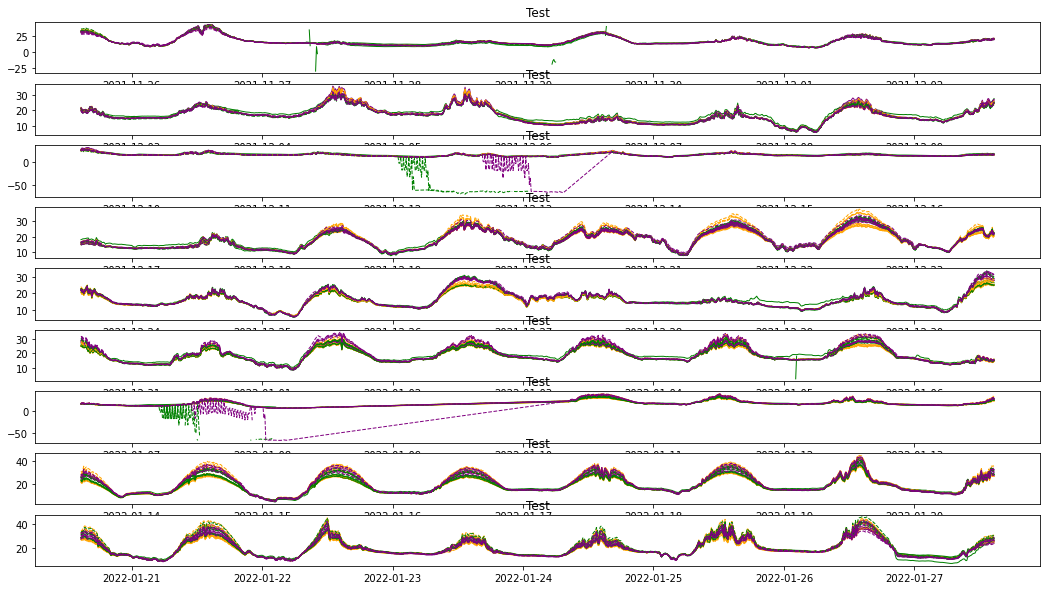

In [30]:
def MakeGraph(DataFrame,ymax,ymin):
    PlotDuration = 1
    Pannels = np.int(ExptDuration/PlotDuration)
    #Create a figure object
    for X in range (0,Pannels):
        if (X == 0):
            StartDate = Data.index.min(axis=0)  #Set start of series at start of data
        else: 
            StartDate = StartDate + timedelta(weeks=PlotDuration)    #increment start date by a week
        StartDateString = StartDate.strftime("%Y-%m-%d")  #Turn this to a string
        EndDate = StartDate + timedelta(weeks=PlotDuration)       #Set start date the specified duration before the end date 
        EndDateString = EndDate.strftime("%Y-%m-%d")           #Turn that into a string
        Position = X+1;
        ax = Fig.add_subplot(Pannels,1,Position)
        GH.AddIndexedPlot(DataFrame.loc[StartDate:EndDate,:],ax,GPs,1)
        plt.title('Test', fontsize=12);
        #plt.ylim(ymin,ymax)
        
Fig = plt.figure(figsize=(18, 10))
MakeGraph(Data.IR_SurfaceTemp,45,0)

Problem with plot 114 so set to NAN.

In [31]:
Data.loc[:,('IR_SurfaceTemp','7D','Peas',2,'Deg C','Avg',114,3)] = np.nan

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [32]:
for irc in Data.loc[:,'IR_SurfaceTemp'].columns:
    key = ('IR_SurfaceTemp',) + irc
    Data.loc[:,key] = Data.loc[:,key].where(Data.loc[:,key]>3,np.nan)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\pandas\core\i

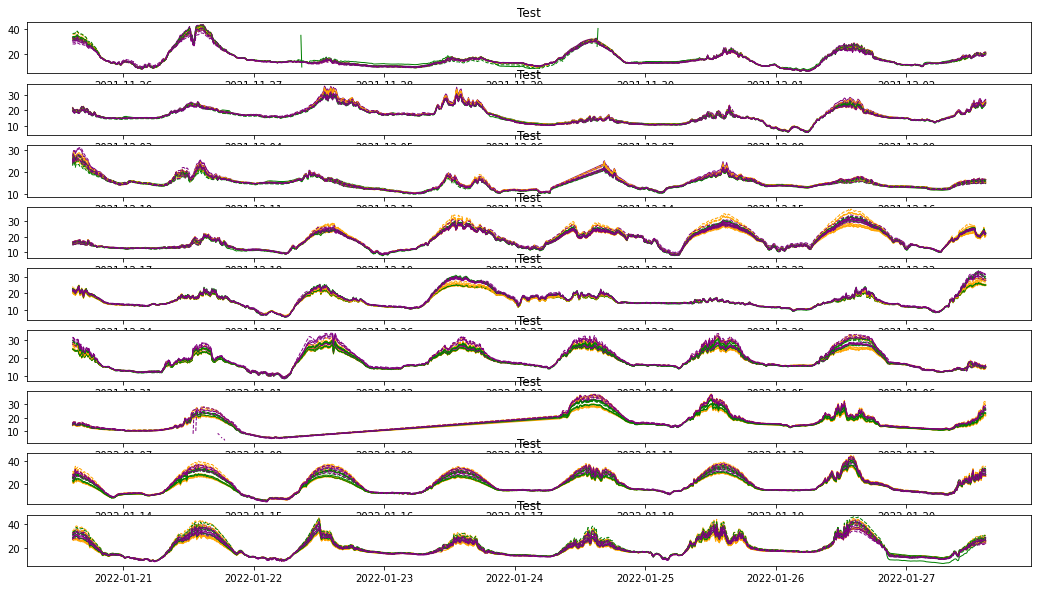

In [33]:
Fig = plt.figure(figsize=(18, 10))
MakeGraph(Data.IR_SurfaceTemp,45,0)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


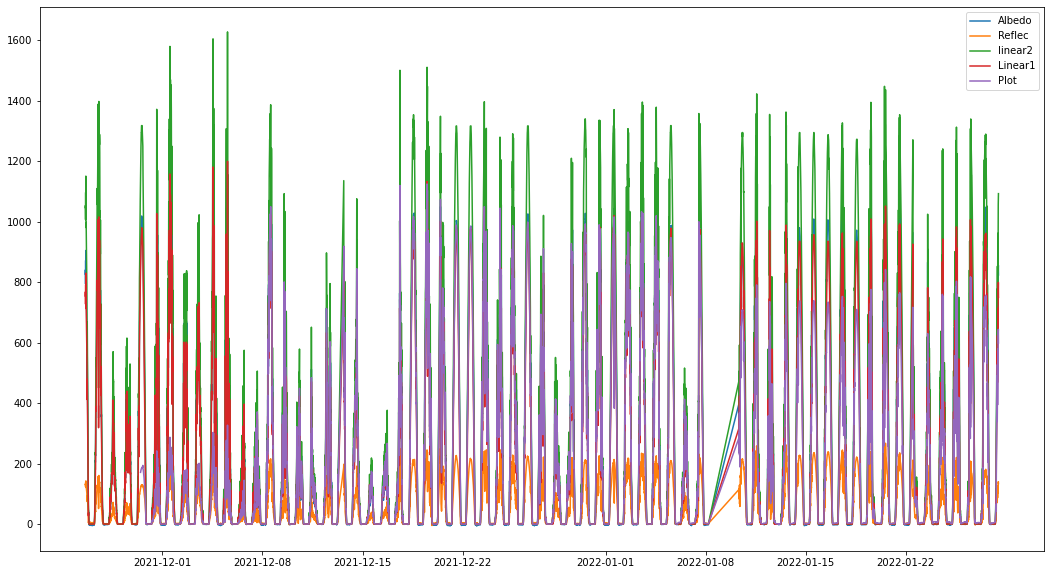

In [34]:
graph = plt.figure(figsize=(18,10))
plt.plot(Data.loc[:,'GlobalRadn'],label = 'Albedo')
plt.plot(Data.loc[:,'ReflectedRadn'],label = 'Reflec')
plt.plot(Data.loc[:,'AboveCanopyPAR2'],label = 'linear2')
plt.plot(Data.loc[:,'AboveCanopyPAR1'],label = 'Linear1')
plt.plot(Data.loc[:,('ReflectedRadnKW','7D','Peas',2,'kW/m^2','Avg',109)]*1000,label = 'Plot')
plt.legend()

Albedo meter is giving good global radiation data

In [35]:
Data.loc[:,('AboveCanopyPAR','Expt','Expt','Expt','mmolPAR','Ave','Expt','Expt')] = Data.loc[:,'GlobalRadn']

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

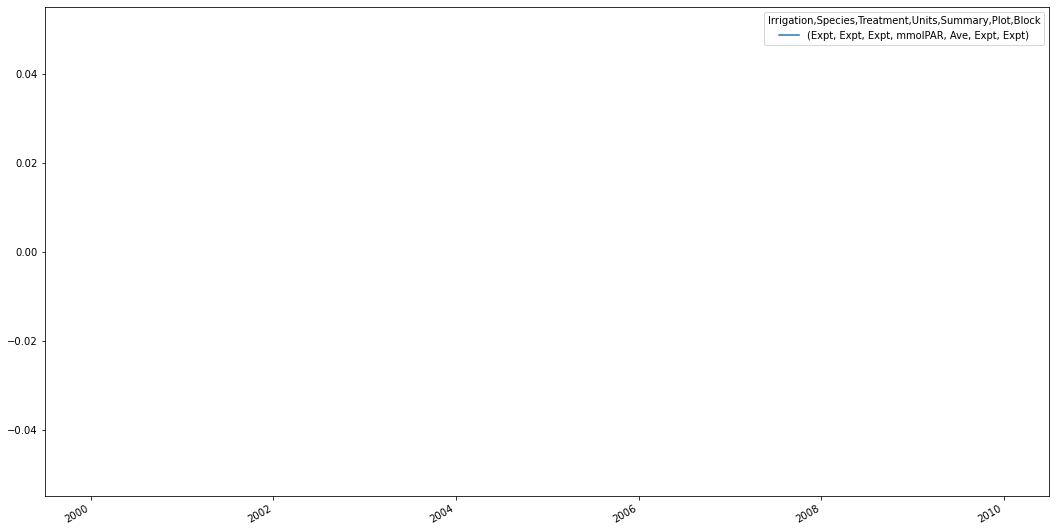

In [36]:
Data.AboveCanopyPAR.plot(figsize = (18,10))

In [37]:
Data.drop(columns = ['AboveCanopyPAR1','AboveCanopyPAR2','AboveCanopyPAR3'], level=0,inplace=True)

# Check Met Data.  Radiation first.

<AxesSubplot:>

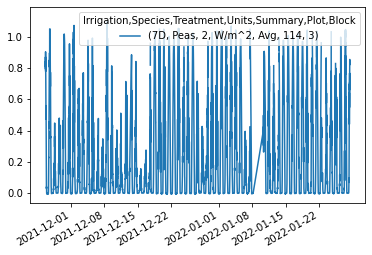

In [38]:
 (Data.loc[:,'GlobalRadn']/1000).plot()

<AxesSubplot:>

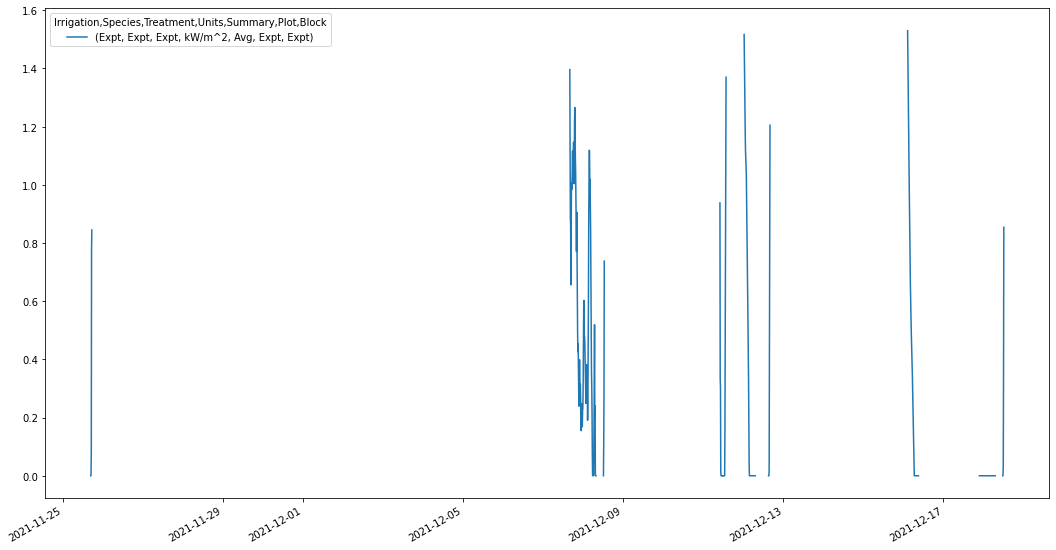

In [39]:
Data.IncomingRadnKW.plot(figsize = (18,10))

## Problem with Radiation sensor, Will Need to patch this with BroadFields data

In [66]:
Data.loc[:,'IncomingRadnMJ'].columns

MultiIndex([('Expt', 'Expt', 'Expt', 'MJ/m^2', 'Tot', 'Expt', 'Expt')],
           names=['Irrigation', 'Species', 'Treatment', 'Units', 'Summary', 'Plot', 'Block'])

In [71]:
BroadFieldsMet = pd.read_pickle('..\General\BroadfieldsMet\BroadFieldsMet.pkl')
Data.loc[:,('IncomingRadnMJ','Expt', 'Expt', 'Expt', 'MJ/m^2', 'Tot', 'Expt', 'Expt')] = BroadFieldsMet.reindex(index = Data.index).loc[:,'IncomingRadnMJ'].values
Data.loc[:,('IncomingRadnKW','Expt', 'Expt', 'Expt', 'MJ/m^2', 'Tot', 'Expt', 'Expt')] = (Data.loc[:,'IncomingRadnMJ'] * 1e6 /600/1000).values 

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

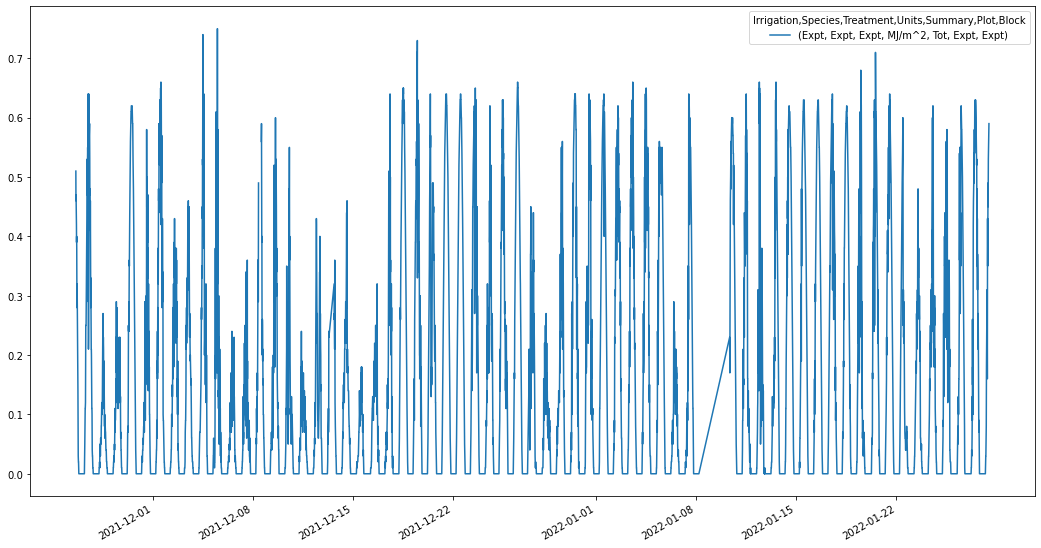

In [72]:
Data.IncomingRadnMJ.plot(figsize = (18,10))

<AxesSubplot:>

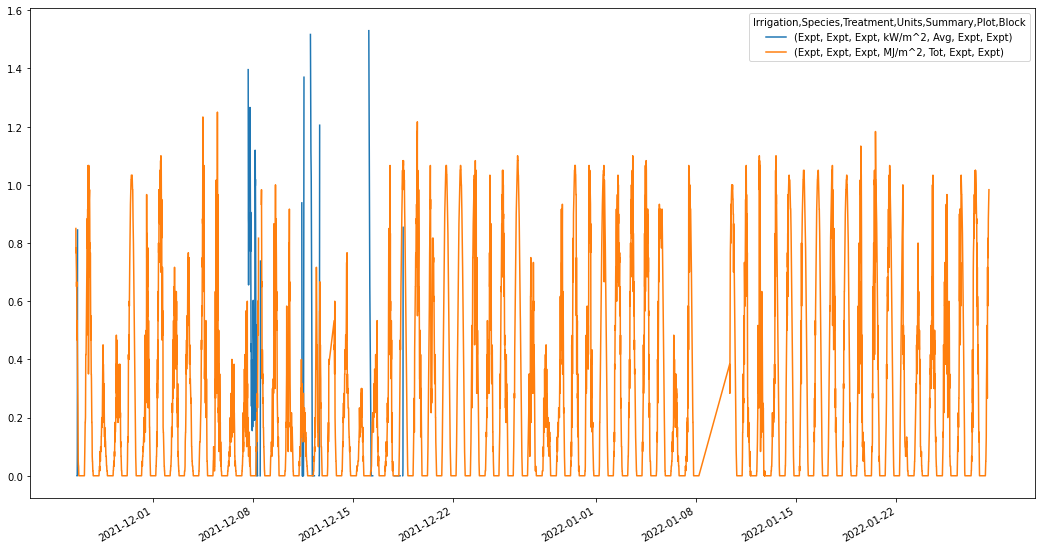

In [73]:
Data.IncomingRadnKW.plot(figsize = (18,10))

## Then Air Temperature

(0.0, 30.0)

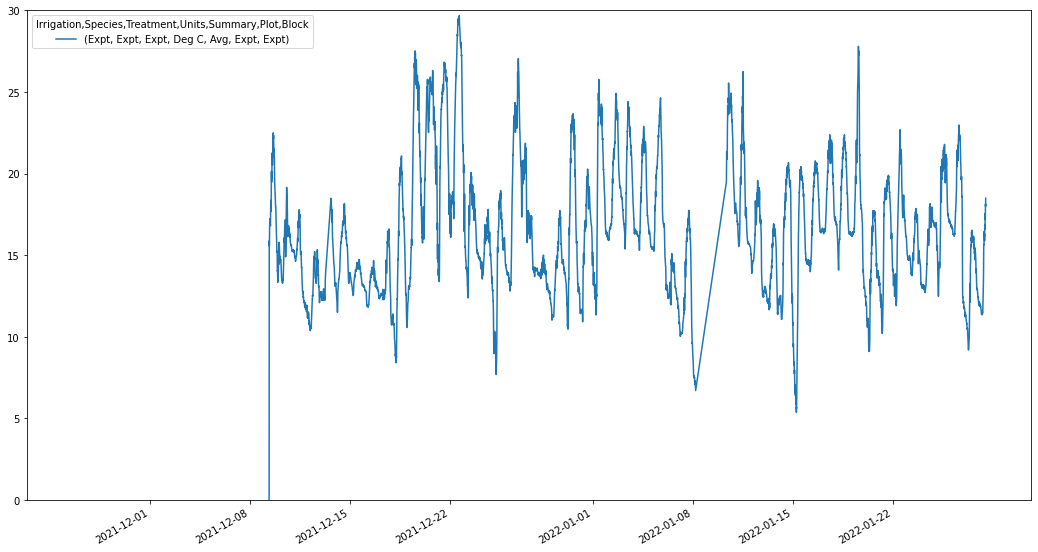

In [74]:
Data.AirTemperature.plot(figsize = (18,10))
plt.ylim(0,30)

In [83]:
Data.loc[:,('AirTemperature','Expt', 'Expt', 'Expt', 'Deg C', 'Avg', 'Expt', 'Expt')] = BroadFieldsMet.reindex(index = Data.index).loc[:,'AirTemperature']

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


<AxesSubplot:>

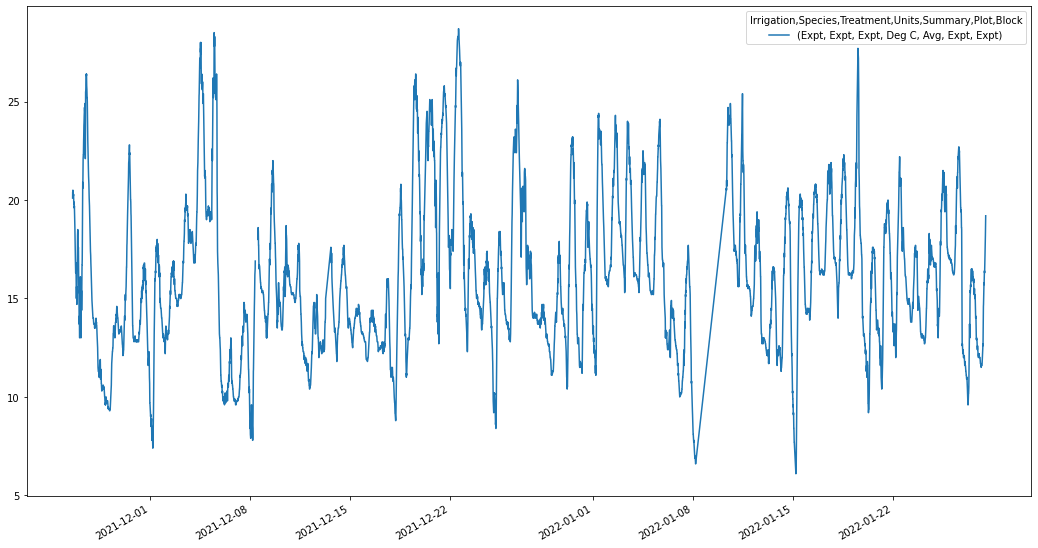

In [84]:
Data.AirTemperature.plot(figsize = (18,10))

## Check humidity

<AxesSubplot:>

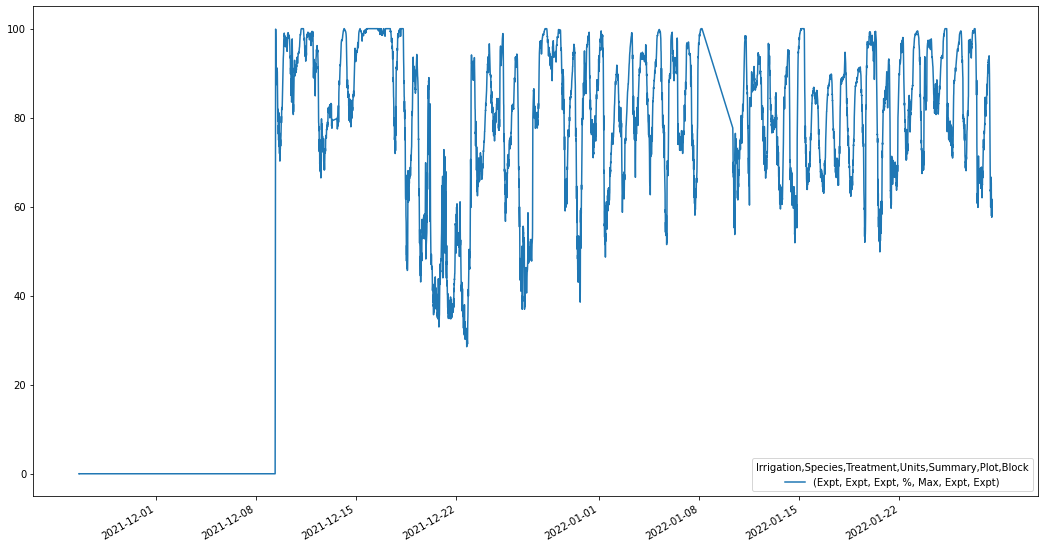

In [85]:
Data.RelativeHumidity.plot(figsize = (18,10))

In [90]:
Data.loc[:,('RelativeHumidity','Expt', 'Expt', 'Expt', '%', 'Max', 'Expt', 'Expt')] = BroadFieldsMet.reindex(index = Data.index)['RelativeHumidity']

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


<AxesSubplot:>

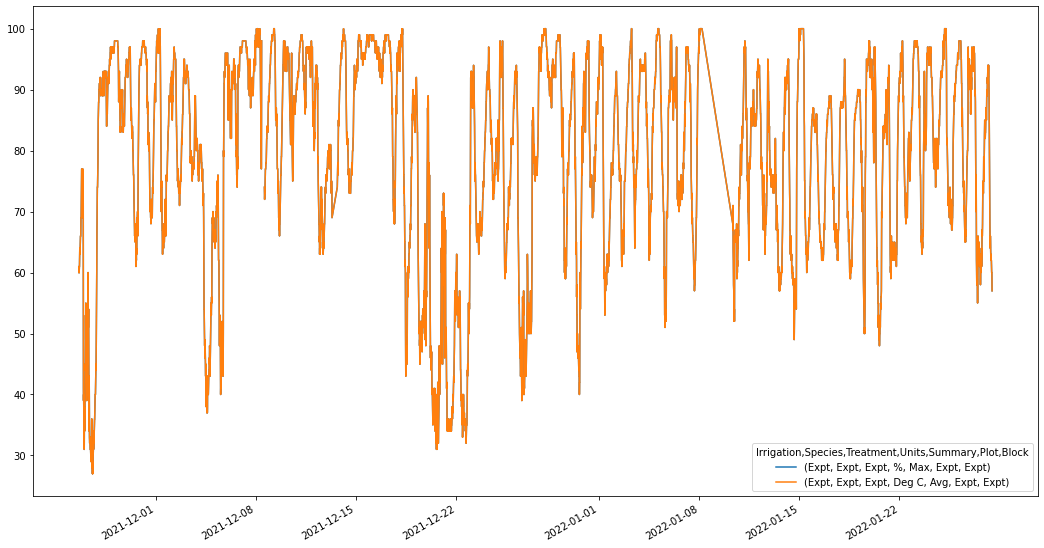

In [91]:
Data.RelativeHumidity.plot(figsize = (18,10))

## Check Wind

<AxesSubplot:>

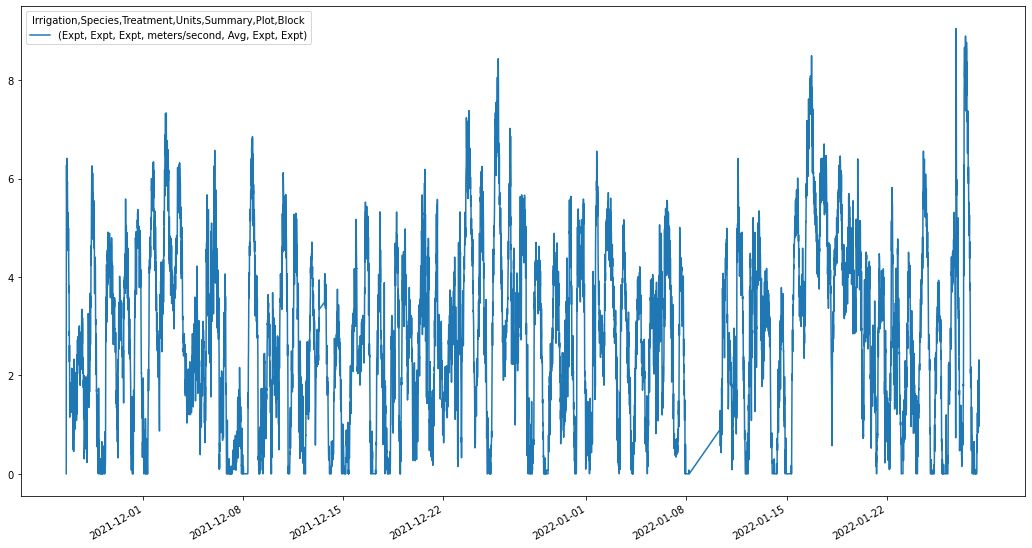

In [92]:
Data.Windspeed.plot(figsize = (18,10))

(0.0, 0.5)

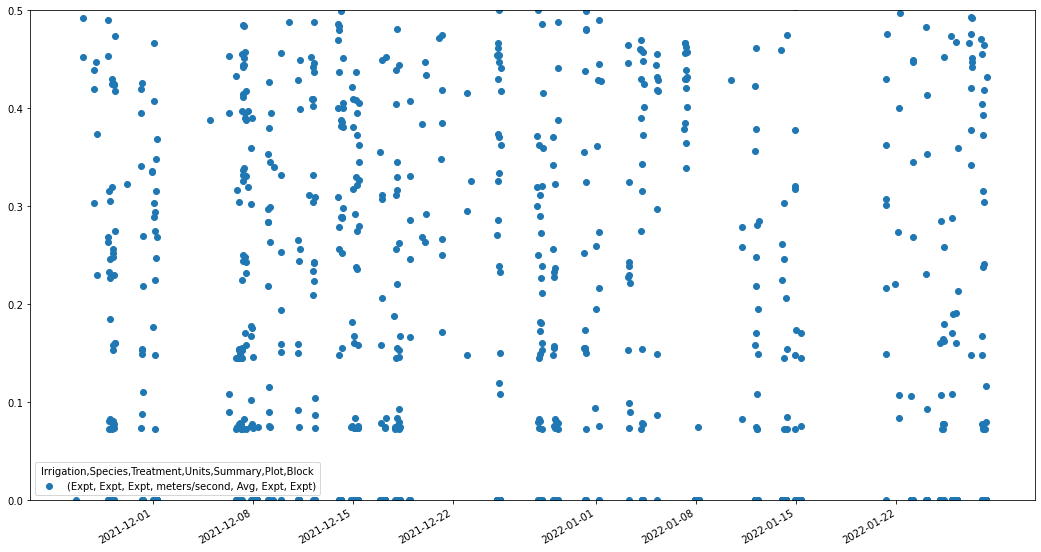

In [93]:
Data.Windspeed.plot(figsize=(18,10),style='o')
plt.plot()
plt.ylim(0,0.5)

### For some reason data logger not zeroing windspeeds <0.36m/x so we need to enforce this

In [95]:
Data.Windspeed = Data.Windspeed.where(Data.Windspeed>0.36,0.0)

(0.0, 0.5)

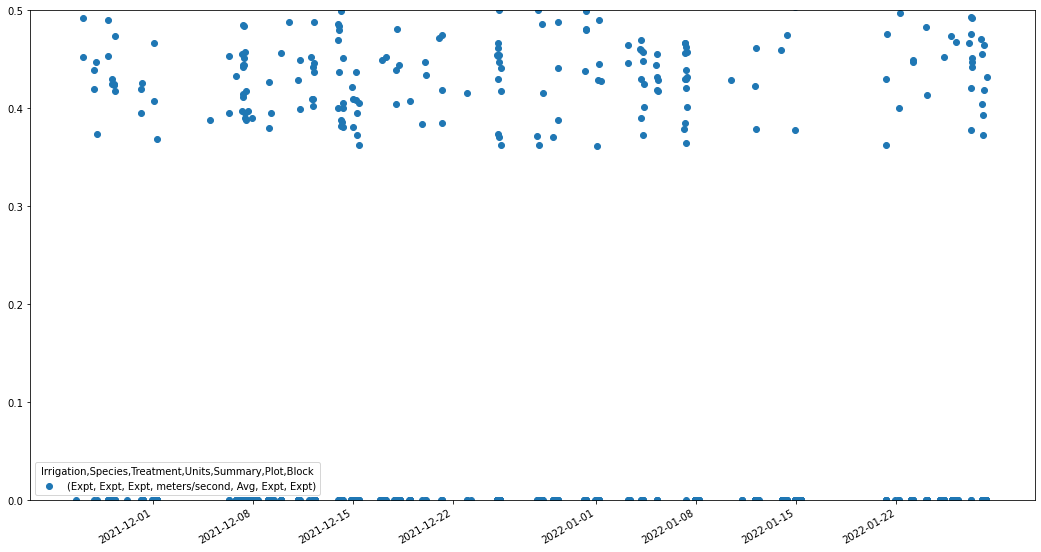

In [96]:
Data.Windspeed.plot(figsize=(18,10),style='o')
#plt.plot([Data.index.min(),Data.index.max()],[0.36,0.36])
plt.ylim(0,0.5)

## Check Leaf Wettness

<AxesSubplot:>

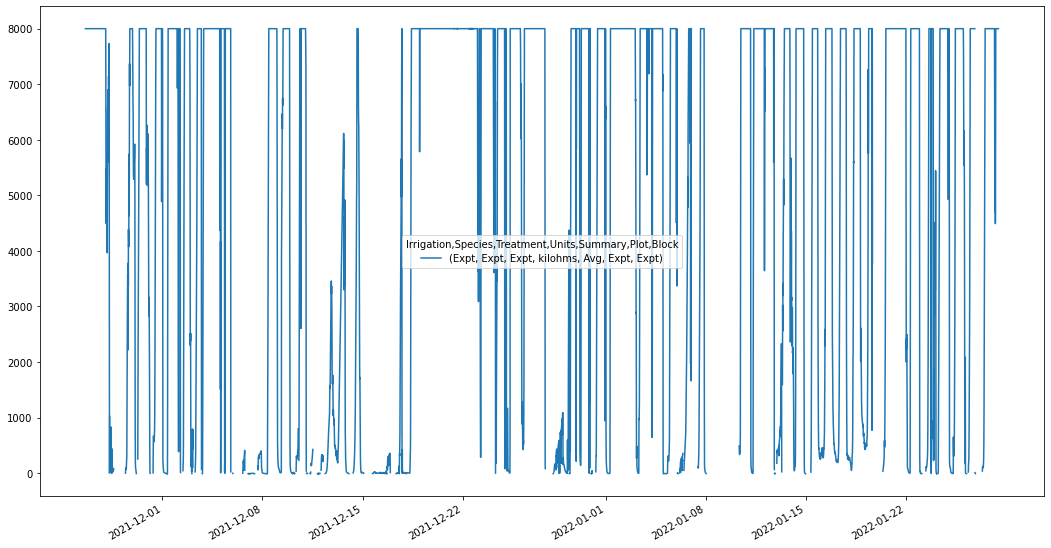

In [97]:
Data.Leafwetness.plot(figsize = (18,10))

# Now we have a clean data set lets pickle it

In [98]:
Data.to_pickle('.\DataFrames\TempAndRadnCleaned.pkl')

<AxesSubplot:>

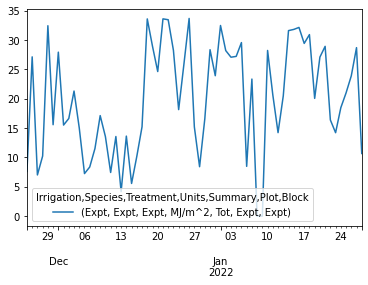

In [99]:
Data.IncomingRadnMJ.resample('d').sum().plot()